In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
#import missingno as ms
from autocorrect import spell
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize
import seaborn as sns
from matplotlib import pylab as plt
import pandasql as ps 
import wordcloud 
from wordcloud import WordCloud, STOPWORDS 


#### 1.Importing wos_index data for analysis

In [93]:
wos_index=pd.read_csv("wos-index.csv")

In [20]:
wos_index

,Title,Title20,Country/Region,SCIE,SSCI,AHCI,ESCI
0,2D MATERIALS,2D MATER,ENGLAND,X,NaN,NaN,NaN
1,3 BIOTECH,3 BIOTECH,GERMANY,X,NaN,NaN,NaN
2,3C EMPRESA,3C EMPRESA,SPAIN,NaN,NaN,NaN,X
3,3C TECNOLOGIA,3C TECNOL,SPAIN,NaN,NaN,NaN,X
4,3C TIC,3C TIC,SPAIN,NaN,NaN,NaN,X
...,...,...,...,...,...,...,...
20937,ZOOTAXA,ZOOTAXA,NEW ZEALAND,X,NaN,NaN,NaN
20938,ZUCHTUNGSKUNDE,ZUCHTUNGSKUNDE,GERMANY,X,NaN,NaN,NaN
20939,ZUTOT,ZUTOT,NETHERLANDS,NaN,NaN,NaN,X
20940,ZYGON,ZYGON,UNITED STATES,NaN,X,X,NaN


###### 1.1 Checking my data for missing values

In [21]:
wos_index.isnull().sum()

Title                 0
Title20               0
Country/Region        0
SCIE              11433
SSCI              17431
AHCI              19158
ESCI              13667
dtype: int64

###### 1.2 Encoding missing Values

In [22]:
wos_index['SCIE'] = wos_index['SCIE'].replace({'X':1,
                             np.NaN:0},)
wos_index['SSCI'] = wos_index['SSCI'].replace({'X':1,    
                             np.NaN:0},)
wos_index['AHCI'] = wos_index['AHCI'].replace({'X':1,
                             np.NaN:0},)
wos_index['ESCI'] = wos_index['ESCI'].replace({'X':0.75,
                             np.NaN:0},)

###### 1.3 Intergrating the columns to come up with a single column named result

In [23]:
wos_index['RESULT'] = wos_index.sum(axis ='columns')

<ipython-input-23-a38a38b9c7b7>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  wos_index['RESULT'] = wos_index.sum(axis ='columns')


In [24]:
#wos_index["RESULT"]= wos_index['SCIE']+wos_index['SSCI']+wos_index['AHCI']+wos_index['ESCI']

In [25]:
wos_index.head()

,Title,Title20,Country/Region,SCIE,SSCI,AHCI,ESCI,RESULT
0,2D MATERIALS,2D MATER,ENGLAND,1.0,0.0,0.0,0.00,1.00
1,3 BIOTECH,3 BIOTECH,GERMANY,1.0,0.0,0.0,0.00,1.00
2,3C EMPRESA,3C EMPRESA,SPAIN,0.0,0.0,0.0,0.75,0.75
3,3C TECNOLOGIA,3C TECNOL,SPAIN,0.0,0.0,0.0,0.75,0.75
4,3C TIC,3C TIC,SPAIN,0.0,0.0,0.0,0.75,0.75


###### 1.4 Droping the columns we used for encoding, there are no longer useful

In [26]:
wos_index=wos_index.drop(["SCIE","SSCI","AHCI","ESCI","Title20"],axis=1,)

In [27]:
wos_index

,Title,Country/Region,RESULT
0,2D MATERIALS,ENGLAND,1.00
1,3 BIOTECH,GERMANY,1.00
2,3C EMPRESA,SPAIN,0.75
3,3C TECNOLOGIA,SPAIN,0.75
4,3C TIC,SPAIN,0.75
...,...,...,...
20937,ZOOTAXA,NEW ZEALAND,1.00
20938,ZUCHTUNGSKUNDE,GERMANY,1.00
20939,ZUTOT,NETHERLANDS,0.75
20940,ZYGON,UNITED STATES,2.00


In [28]:
wos_index[wos_index['RESULT']>=2]

,Title,Country/Region,RESULT
76,ACM JOURNAL ON COMPUTING AND CULTURAL HERITAGE,UNITED STATES,2.0
121,ACROSS LANGUAGES AND CULTURES,HUNGARY,2.0
169,ACTA BIOETHICA,CHILE,2.0
231,ACTA HISTRIAE,SLOVENIA,2.0
294,ACTA PAULISTA DE ENFERMAGEM,BRAZIL,2.0
...,...,...,...
20849,ZEITSCHRIFT FUR DIALEKTOLOGIE UND LINGUISTIK,GERMANY,2.0
20864,ZEITSCHRIFT FUR GERONTOLOGIE UND GERIATRIE,GERMANY,2.0
20889,ZEITSCHRIFT FUR PSYCHOSOMATISCHE MEDIZIN UND P...,GERMANY,2.0
20899,ZEITSCHRIFT FUR SPRACHWISSENSCHAFT,GERMANY,2.0


There are some inconsistences on the result column.All values will be fixed back to 1

In [29]:
wos_index['RESULT'] = wos_index['RESULT'].transform(lambda x: 1 if x >= 1 else 1)

In [31]:
wos_index[wos_index['RESULT']>=2]

,Title,Country/Region,RESULT


In [30]:
wos_index[wos_index['Title']=='ZYGON']

,Title,Country/Region,RESULT
20940,ZYGON,UNITED STATES,1


Everything is  okey now

In [650]:
wos_index['Title'].value_counts()

2D MATERIALS                             1
LINGUAS & LETRAS                         1
LINGUISTICS OF THE TIBETO-BURMAN AREA    1
LINGUISTICS AND PHILOSOPHY               1
LINGUISTICS AND EDUCATION                1
                                        ..
FRENCH FORUM                             1
FRENCH CULTURAL STUDIES                  1
FREE RADICAL RESEARCH                    1
FREE RADICAL BIOLOGY AND MEDICINE        1
ZYGOTE                                   1
Name: Title, Length: 20942, dtype: int64

In [651]:
wos_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20942 entries, 0 to 20941
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           20942 non-null  object 
 1   Country/Region  20942 non-null  object 
 2   RESULT          20942 non-null  float64
dtypes: float64(1), object(2)
memory usage: 491.0+ KB


#### 2.Importing the scopus data for analysis

In [94]:
scopus=pd.read_excel("scopus_2022_CiteScore.xlsx")

C:\Users\trymo\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [653]:
scopus

,Source title,CiteScore,Highest percentile,2018-21 Citations,2018-21 Documents,% Cited,SNIP,SJR,Publisher
0,Ca-A Cancer Journal for Clinicians,716.2,99.0%\n1/360\nOncology,76632,107,91,173.932,56.204,Wiley-Blackwell
1,Nature Reviews Molecular Cell Biology,140.9,99.0%\n1/386\nMolecular Biology,28743,204,90,19.069,33.213,Springer Nature
2,The Lancet,115.3,99.0%\n1/826\nGeneral Medicine,198711,1723,76,33.801,15.652,Elsevier
3,New England Journal of Medicine,110.5,99.0%\n2/826\nGeneral Medicine,261485,2367,85,20.135,24.907,Massachusetts Medical Society
4,Reviews of Modern Physics,102.0,99.0%\n1/240\nGeneral Physics and Astronomy,14489,142,97,16.262,21.151,American Physical Society
...,...,...,...,...,...,...,...,...,...
995,Depression and Anxiety,11.1,98.0%\n6/292\nClinical Psychology,4837,436,89,2.678,2.657,Wiley-Blackwell
996,European Journal of Information Systems,11.1,97.0%\n6/247\nLibrary and Information Sciences,1537,138,88,2.879,2.201,Taylor & Francis
997,Food Research International,11.1,96.0%\n13/338\nFood Science,38038,3440,88,1.884,1.248,Elsevier
998,Geoderma,11.1,97.0%\n4/145\nSoil Science,23489,2125,88,2.048,1.875,Elsevier


###### 2.1 Checking my data and making some minor investigations

In [785]:
#scopus.info()

In [655]:
scopus.isnull().sum()

Source title          0
CiteScore             0
Highest percentile    0
2018-21 Citations     0
2018-21 Documents     0
% Cited               0
SNIP                  9
SJR                   8
Publisher             0
dtype: int64

###### 2.2 Seperating string values and numerical values on the percentage column

In [656]:
scopus['Percentage']= scopus['Highest percentile'].str[0:4]

In [657]:
scopus['Discipline']= scopus['Highest percentile'].str[12:]   # ? needs tuning

In [658]:
scopus.drop('Highest percentile',axis=1,inplace=True)

In [659]:
scopus.head()

,Source title,CiteScore,2018-21 Citations,2018-21 Documents,% Cited,SNIP,SJR,Publisher,Percentage,Discipline
0,Ca-A Cancer Journal for Clinicians,716.2,76632,107,91,173.932,56.204,Wiley-Blackwell,99.0,Oncology
1,Nature Reviews Molecular Cell Biology,140.9,28743,204,90,19.069,33.213,Springer Nature,99.0,Molecular Biology
2,The Lancet,115.3,198711,1723,76,33.801,15.652,Elsevier,99.0,General Medicine
3,New England Journal of Medicine,110.5,261485,2367,85,20.135,24.907,Massachusetts Medical Society,99.0,General Medicine
4,Reviews of Modern Physics,102.0,14489,142,97,16.262,21.151,American Physical Society,99.0,General Physics and Astronomy


###### 2.3 Investigating dependance between my variables

In [660]:
scopus[[ 'SNIP',  'SJR','Percentage','CiteScore','2018-21 Citations','2018-21 Documents','% Cited']].corr()

,SNIP,SJR,CiteScore,2018-21 Citations,2018-21 Documents,% Cited
SNIP,1.000000,0.668638,0.936780,0.069435,-0.082559,-0.039689
SJR,0.668638,1.000000,0.723233,0.164816,-0.071465,-0.061426
CiteScore,0.936780,0.723233,1.000000,0.153173,-0.038265,0.054792
2018-21 Citations,0.069435,0.164816,0.153173,1.000000,0.877343,0.032893
2018-21 Documents,-0.082559,-0.071465,-0.038265,0.877343,1.000000,0.022752
% Cited,-0.039689,-0.061426,0.054792,0.032893,0.022752,1.000000


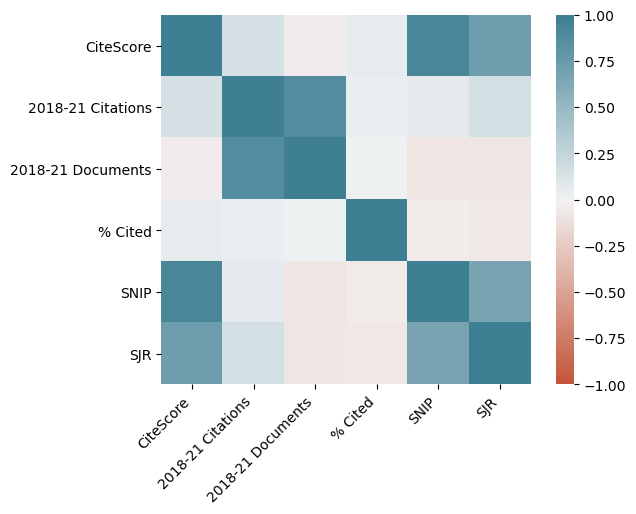

In [661]:
corr = scopus.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

You have observed that citeScore is highly correlated to SNIP and SJR.Since SNIP and SJR have missing values i have chosen to drop them.They might cause high dependancy and multicollinearity in the model

In [662]:
scopus.drop(['SNIP','SJR'],axis=1,inplace=True)

In [663]:
scopus.head(2)

,Source title,CiteScore,2018-21 Citations,2018-21 Documents,% Cited,Publisher,Percentage,Discipline
0,Ca-A Cancer Journal for Clinicians,716.2,76632,107,91,Wiley-Blackwell,99.0,Oncology
1,Nature Reviews Molecular Cell Biology,140.9,28743,204,90,Springer Nature,99.0,Molecular Biology


In [664]:
scopus.shape

(1000, 8)

In [665]:
scopus.isnull().sum()

Source title         0
CiteScore            0
2018-21 Citations    0
2018-21 Documents    0
% Cited              0
Publisher            0
Percentage           0
Discipline           0
dtype: int64

My scopus data is ready to be merged with other data frames.I will leave it for now and reconsider it later

In [666]:
scopus['Publisher'].value_counts()

Elsevier                                                322
Springer Nature                                         155
Wiley-Blackwell                                         108
IEEE                                                     50
Annual Reviews Inc.                                      42
                                                       ... 
Epidemiology Program Office                               1
Cell Physiol Biochem Press                                1
KeAi Communications Co                                    1
Chongqing University of Posts and Telecommunications      1
Portland Press, Ltd.                                      1
Name: Publisher, Length: 108, dtype: int64

In [667]:
articles_df[pd.isnull(articles_df['Source Title'])==True] # returns the rows of pubmed file whose doi is nan value

,Publication Type,Authors,Author Full Names,Article Title,Source Title,Document Type,Author Keywords,Abstract,Addresses,Reprint Addresses,...,"Times Cited, All Databases",180 Day Usage Count,Since 2013 Usage Count,Publication Year,Volume,DOI,DOI Link,WoS Categories,Date of Export,UT (Unique WOS ID)


In [32]:
scopus.columns

Index(['Source title', 'CiteScore', '2018-21 Citations', '2018-21 Documents',
       '% Cited', 'Publisher', 'Percentage', 'Discipline'],
      dtype='object')

#### 3. Importing and combining articles data frames

In [44]:
df2=pd.read_excel('savedrecs.xls')

In [45]:
df2.shape

(1000, 71)

In [46]:
df3=pd.read_excel('savedrecs (1).xls')

In [47]:
df3.shape

(1000, 71)

In [48]:
df4=pd.read_excel('savedrecs (2).xls')

In [49]:
df4.shape

(1000, 71)

In [50]:
df5=pd.read_excel('savedrecs (3).xls')

In [51]:
 df5.shape

(1000, 71)

In [52]:
df6=pd.read_excel('savedrecs (4).xls')

In [53]:
df6.shape

(1000, 71)

In [54]:
df7=pd.read_excel('savedrecs (5).xls')

In [55]:
df7.shape

(1000, 71)

In [56]:
df8=pd.read_excel('savedrecs (6).xls')

In [57]:
df8.shape

(1000, 71)

In [58]:
df9=pd.read_excel('savedrecs (7).xls')

In [59]:
df9.shape

(1000, 71)

In [60]:
df10=pd.read_excel('savedrecs (8).xls')

In [61]:
df10.shape

(251, 71)

In [62]:
dfcon=pd.concat([df2, df3, df4, df5,df6,df7,df8,df9,df10], axis=0)

In [63]:
dfcon.head(2)

,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,Article Title,Source Title,...,WoS Categories,Web of Science Index,Research Areas,IDS Number,Pubmed Id,Open Access Designations,Highly Cited Status,Hot Paper Status,Date of Export,UT (Unique WOS ID)
0,C,"Kaur, B",NaN,NaN,IEEE,"Kaur, Baljeet",NaN,NaN,Data Science: Empowering Business Strategy,2019 IEEE PUNE SECTION INTERNATIONAL CONFERENC...,...,"Computer Science, Artificial Intelligence; Com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-17,WOS:000674974200033
1,J,"Salas-Rueda, RA; Salas-Rueda, RD",NaN,NaN,NaN,"Salas-Rueda, Ricardo-Adan; Salas-Rueda, Rodrig...",NaN,NaN,Use of data science and machine learning to an...,DIGITAL EDUCATION REVIEW,...,Education & Educational Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-17,WOS:000505060900008


In [64]:
dfcon.shape

(8251, 71)

In [65]:
dfcon.columns

Index(['Publication Type', 'Authors', 'Book Authors', 'Book Editors',
       'Book Group Authors', 'Author Full Names', 'Book Author Full Names',
       'Group Authors', 'Article Title', 'Source Title', 'Book Series Title',
       'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title',
       'Conference Date', 'Conference Location', 'Conference Sponsor',
       'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses',
       'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Name Preferred',
       'Funding Text', 'Cited References', 'Cited Reference Count',
       'Times Cited, WoS Core', 'Times Cited, All Databases',
       '180 Day Usage Count', 'Since 2013 Usage Count', 'Publisher',
       'Publisher City', 'Publisher Address', 'ISSN', 'eISSN', 'ISBN',
       'Journal Abbreviation', 'Journal ISO Abbreviation', 'Publication Date',
       'Publication Year', 'Volume', 'Issue', 'Pa

###### 3.1 Selecting only Journals

In [66]:
#'Publication Type': J=Journal; B=Book; S=Series; C=Conference prooceeding

In [67]:
dfcon['Publication Type'].value_counts()

J    5934
C    2263
S      46
B       8
Name: Publication Type, dtype: int64

In [68]:
articles_df=dfcon[(dfcon['Publication Type'] == 'J')]

In [69]:
articles_df.head()

,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,Article Title,Source Title,...,WoS Categories,Web of Science Index,Research Areas,IDS Number,Pubmed Id,Open Access Designations,Highly Cited Status,Hot Paper Status,Date of Export,UT (Unique WOS ID)
1,J,"Salas-Rueda, RA; Salas-Rueda, RD",NaN,NaN,NaN,"Salas-Rueda, Ricardo-Adan; Salas-Rueda, Rodrig...",NaN,NaN,Use of data science and machine learning to an...,DIGITAL EDUCATION REVIEW,...,Education & Educational Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-17,WOS:000505060900008
2,J,"Salas-Rueda, RA; Salas-Rueda, EP; Salas-Rueda, RD",NaN,NaN,NaN,"Salas-Rueda, Ricardo A.; Salas-Rueda, Erika P....",NaN,NaN,Students' perceptions about the use of the tab...,CAMPUS VIRTUALES,...,Education & Educational Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-17,WOS:000472158000006
3,J,"Al-Anqoudi, Y; Al-Hamdani, A; Al-Badawi, M; He...",NaN,NaN,NaN,"Al-Anqoudi, Younis; Al-Hamdani, Abdullah; Al-B...",NaN,NaN,Using Machine Learning in Business Process Re-...,BIG DATA AND COGNITIVE COMPUTING,...,"Computer Science, Artificial Intelligence; Com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-17,WOS:000735969000001
4,J,"Mrzic, E; Zaimovic, T",NaN,NaN,NaN,"Mrzic, Erol; Zaimovic, Tarik",NaN,NaN,Data Science Methods and Machine Learning Algo...,TEM JOURNAL-TECHNOLOGY EDUCATION MANAGEMENT IN...,...,"Computer Science, Information Systems",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-17,WOS:000565865300044
5,J,"Reis, C; Ruivo, P; Oliveira, T; Faroleiro, P",NaN,NaN,NaN,"Reis, Carolina; Ruivo, Pedro; Oliveira, Tiago;...",NaN,NaN,Assessing the drivers of machine learning busi...,JOURNAL OF BUSINESS RESEARCH,...,Business,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-17,WOS:000556889900021


In [71]:
articles_df['Publication Type'].value_counts()

J    5934
Name: Publication Type, dtype: int64

In [72]:
articles_df.shape

(5934, 71)

In [73]:
# Checking if there are duplicates
articles_df[articles_df.duplicated()==True]

,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,Article Title,Source Title,...,WoS Categories,Web of Science Index,Research Areas,IDS Number,Pubmed Id,Open Access Designations,Highly Cited Status,Hot Paper Status,Date of Export,UT (Unique WOS ID)


In [74]:
#articles_df.info()

In [75]:
articles_df.isnull().sum()

Publication Type               0
Authors                        0
Book Authors                5934
Book Editors                5934
Book Group Authors          5934
                            ... 
Open Access Designations    5934
Highly Cited Status         5934
Hot Paper Status            5934
Date of Export                 0
UT (Unique WOS ID)             0
Length: 71, dtype: int64

In [76]:
#articles_df.columns


###### 3.2 Drop articles_df.info Columns where all values are missing

In [77]:
articles_df.dropna(how='all', axis='columns')

,Publication Type,Authors,Author Full Names,Group Authors,Article Title,Source Title,Document Type,Conference Title,Conference Date,Conference Location,...,Meeting Abstract,Start Page,End Page,Article Number,DOI,DOI Link,Early Access Date,WoS Categories,Date of Export,UT (Unique WOS ID)
1,J,"Salas-Rueda, RA; Salas-Rueda, RD","Salas-Rueda, Ricardo-Adan; Salas-Rueda, Rodrig...",NaN,Use of data science and machine learning to an...,DIGITAL EDUCATION REVIEW,Article,NaN,NaN,NaN,...,NaN,117,151,NaN,NaN,NaN,NaN,Education & Educational Research,2022-06-17,WOS:000505060900008
2,J,"Salas-Rueda, RA; Salas-Rueda, EP; Salas-Rueda, RD","Salas-Rueda, Ricardo A.; Salas-Rueda, Erika P....",NaN,Students' perceptions about the use of the tab...,CAMPUS VIRTUALES,Article,NaN,NaN,NaN,...,NaN,75,86,NaN,NaN,NaN,NaN,Education & Educational Research,2022-06-17,WOS:000472158000006
3,J,"Al-Anqoudi, Y; Al-Hamdani, A; Al-Badawi, M; He...","Al-Anqoudi, Younis; Al-Hamdani, Abdullah; Al-B...",NaN,Using Machine Learning in Business Process Re-...,BIG DATA AND COGNITIVE COMPUTING,Article,NaN,NaN,NaN,...,NaN,NaN,NaN,61,10.3390/bdcc5040061,0.0,NaN,"Computer Science, Artificial Intelligence; Com...",2022-06-17,WOS:000735969000001
4,J,"Mrzic, E; Zaimovic, T","Mrzic, Erol; Zaimovic, Tarik",NaN,Data Science Methods and Machine Learning Algo...,TEM JOURNAL-TECHNOLOGY EDUCATION MANAGEMENT IN...,Article,NaN,NaN,NaN,...,NaN,1179,1185,NaN,10.18421/TEM93-44,0.0,NaN,"Computer Science, Information Systems",2022-06-17,WOS:000565865300044
5,J,"Reis, C; Ruivo, P; Oliveira, T; Faroleiro, P","Reis, Carolina; Ruivo, Pedro; Oliveira, Tiago;...",NaN,Assessing the drivers of machine learning busi...,JOURNAL OF BUSINESS RESEARCH,Article,NaN,NaN,NaN,...,NaN,232,243,NaN,10.1016/j.jbusres.2020.05.053,0.0,NaN,Business,2022-06-17,WOS:000556889900021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,J,"Holmqvist, K; Orbom, SL; Hooge, ITC; Niehorste...","Holmqvist, Kenneth; Oerbom, Saga Lee; Hooge, I...",NaN,Eye tracking: empirical foundations for a mini...,BEHAVIOR RESEARCH METHODS,Article; Early Access,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.3758/s13428-021-01762-8,0.0,APR 2022,"Psychology, Mathematical; Psychology, Experime...",2022-06-17,WOS:000781225100001
247,J,"Coventry, P; Bower, P; Blakemore, A; Baker, E;...","Coventry, Peter; Bower, Peter; Blakemore, Amy;...",NaN,Satisfaction with a digitally-enabled telephon...,NPJ DIGITAL MEDICINE,Article,NaN,NaN,NaN,...,NaN,NaN,NaN,5,10.1038/s41746-019-0080-6,0.0,NaN,Health Care Sciences & Services; Medical Infor...,2022-06-17,WOS:000462448900002
248,J,"Wang, K; Goldenberg, A; Dorison, CA; Miller, J...","Wang, Ke; Goldenberg, Amit; Dorison, Charles A...",NaN,A multi-country test of brief reappraisal inte...,NATURE HUMAN BEHAVIOUR,Article,NaN,NaN,NaN,...,NaN,1089,+,NaN,10.1038/s41562-021-01173-x,0.0,AUG 2021,"Psychology, Biological; Multidisciplinary Scie...",2022-06-17,WOS:000680374200002
249,J,"Gatti, RC; Reich, PB; Gamarra, JGP; Crowther, ...","Gatti, Roberto Cazzolla; Reich, Peter B.; Gama...",NaN,The number of tree species on Earth,PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCE...,Article,NaN,NaN,NaN,...,NaN,NaN,NaN,e2115329119,10.1073/pnas.2115329119,0.0,NaN,Multidisciplinary Sciences,2022-06-17,WOS:000758488400010


In [78]:
#articles_df.info()

In [79]:
articles_df.isnull().sum()

Publication Type               0
Authors                        0
Book Authors                5934
Book Editors                5934
Book Group Authors          5934
                            ... 
Open Access Designations    5934
Highly Cited Status         5934
Hot Paper Status            5934
Date of Export                 0
UT (Unique WOS ID)             0
Length: 71, dtype: int64

In [80]:
# Having the null value in Percentage for easy representation

articles_df.isnull().mean() * 100

Publication Type              0.0
Authors                       0.0
Book Authors                100.0
Book Editors                100.0
Book Group Authors          100.0
                            ...  
Open Access Designations    100.0
Highly Cited Status         100.0
Hot Paper Status            100.0
Date of Export                0.0
UT (Unique WOS ID)            0.0
Length: 71, dtype: float64

In [81]:
## Keep columns which have atleast 80% not null values and drop others
articles_df.dropna(thresh=len(articles_df)*.8, axis='columns',inplace=True)

<ipython-input-81-b2097753ae3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df.dropna(thresh=len(articles_df)*.8, axis='columns',inplace=True)


In [82]:
articles_df.isnull().mean() * 100

Publication Type               0.000000
Authors                        0.000000
Author Full Names              0.000000
Article Title                  0.000000
Source Title                   0.000000
Document Type                  0.000000
Author Keywords               11.206606
Abstract                       1.550388
Addresses                      0.185372
Reprint Addresses              0.556117
Email Addresses                3.926525
Cited Reference Count          0.000000
Times Cited, WoS Core          0.000000
Times Cited, All Databases     0.000000
180 Day Usage Count            0.000000
Since 2013 Usage Count         0.000000
Publication Year               8.072127
Volume                         8.409168
DOI                            3.673745
DOI Link                       3.673745
WoS Categories                 0.000000
Date of Export                 0.000000
UT (Unique WOS ID)             0.000000
dtype: float64

In [83]:
articles_df.head(2)

,Publication Type,Authors,Author Full Names,Article Title,Source Title,Document Type,Author Keywords,Abstract,Addresses,Reprint Addresses,...,"Times Cited, All Databases",180 Day Usage Count,Since 2013 Usage Count,Publication Year,Volume,DOI,DOI Link,WoS Categories,Date of Export,UT (Unique WOS ID)
1,J,"Salas-Rueda, RA; Salas-Rueda, RD","Salas-Rueda, Ricardo-Adan; Salas-Rueda, Rodrig...",Use of data science and machine learning to an...,DIGITAL EDUCATION REVIEW,Article,GeoGebra; higher education; data science; mach...,This mixed research analyzes the use of GeoGeb...,"[Salas-Rueda, Ricardo-Adan] Univ Nacl Autonoma...","Salas-Rueda, RA (corresponding author), Univ N...",...,0,2,4,2019.0,NaN,NaN,NaN,Education & Educational Research,2022-06-17,WOS:000505060900008
2,J,"Salas-Rueda, RA; Salas-Rueda, EP; Salas-Rueda, RD","Salas-Rueda, Ricardo A.; Salas-Rueda, Erika P....",Students' perceptions about the use of the tab...,CAMPUS VIRTUALES,Article,Mobile devices; Higher education; Tablet; data...,This quantitative research aims to analyze the...,"[Salas-Rueda, Ricardo A.] Univ La Salle Mexico...","Salas-Rueda, RA (corresponding author), Univ L...",...,5,0,6,2019.0,8,NaN,NaN,Education & Educational Research,2022-06-17,WOS:000472158000006


In [84]:
articles_df.columns

Index(['Publication Type', 'Authors', 'Author Full Names', 'Article Title',
       'Source Title', 'Document Type', 'Author Keywords', 'Abstract',
       'Addresses', 'Reprint Addresses', 'Email Addresses',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publication Year', 'Volume', 'DOI',
       'DOI Link', 'WoS Categories', 'Date of Export', 'UT (Unique WOS ID)'],
      dtype='object')

In [85]:
articles_df.dtypes

Publication Type               object
Authors                        object
Author Full Names              object
Article Title                  object
Source Title                   object
Document Type                  object
Author Keywords                object
Abstract                       object
Addresses                      object
Reprint Addresses              object
Email Addresses                object
Cited Reference Count           int64
Times Cited, WoS Core           int64
Times Cited, All Databases      int64
180 Day Usage Count             int64
Since 2013 Usage Count          int64
Publication Year              float64
Volume                         object
DOI                            object
DOI Link                      float64
WoS Categories                 object
Date of Export                 object
UT (Unique WOS ID)             object
dtype: object

###### 3.3 Some columns with null values are not necessary.I will select the ones that i need only

In [86]:
articles_refined=articles_df[['Publication Type','Article Title','Source Title','180 Day Usage Count','Since 2013 Usage Count','Cited Reference Count','Publication Year','Times Cited, WoS Core','Times Cited, All Databases','Authors','WoS Categories','DOI','Document Type','WoS Categories']]

In [87]:
articles_refined.head(2)

,Publication Type,Article Title,Source Title,180 Day Usage Count,Since 2013 Usage Count,Cited Reference Count,Publication Year,"Times Cited, WoS Core","Times Cited, All Databases",Authors,WoS Categories,DOI,Document Type,WoS Categories
1,J,Use of data science and machine learning to an...,DIGITAL EDUCATION REVIEW,2,4,27,2019.0,0,0,"Salas-Rueda, RA; Salas-Rueda, RD",Education & Educational Research,NaN,Article,Education & Educational Research
2,J,Students' perceptions about the use of the tab...,CAMPUS VIRTUALES,0,6,34,2019.0,4,5,"Salas-Rueda, RA; Salas-Rueda, EP; Salas-Rueda, RD",Education & Educational Research,NaN,Article,Education & Educational Research


I have noticed that there are columns like '180 Day Usage Count' and 'Times Cited Wos Core' that i should drop.They have similar importance with "since 2013 usage count" and "Times Cited,All Databases" respectively

In [88]:
articles_refined.drop(['180 Day Usage Count','Times Cited, WoS Core'],axis=1,inplace=True)

<ipython-input-88-63969b6a1b69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_refined.drop(['180 Day Usage Count','Times Cited, WoS Core'],axis=1,inplace=True)


In [89]:
articles_refined.head()

,Publication Type,Article Title,Source Title,Since 2013 Usage Count,Cited Reference Count,Publication Year,"Times Cited, All Databases",Authors,WoS Categories,DOI,Document Type,WoS Categories
1,J,Use of data science and machine learning to an...,DIGITAL EDUCATION REVIEW,4,27,2019.0,0,"Salas-Rueda, RA; Salas-Rueda, RD",Education & Educational Research,NaN,Article,Education & Educational Research
2,J,Students' perceptions about the use of the tab...,CAMPUS VIRTUALES,6,34,2019.0,5,"Salas-Rueda, RA; Salas-Rueda, EP; Salas-Rueda, RD",Education & Educational Research,NaN,Article,Education & Educational Research
3,J,Using Machine Learning in Business Process Re-...,BIG DATA AND COGNITIVE COMPUTING,10,59,2021.0,1,"Al-Anqoudi, Y; Al-Hamdani, A; Al-Badawi, M; He...","Computer Science, Artificial Intelligence; Com...",10.3390/bdcc5040061,Article,"Computer Science, Artificial Intelligence; Com..."
4,J,Data Science Methods and Machine Learning Algo...,TEM JOURNAL-TECHNOLOGY EDUCATION MANAGEMENT IN...,2,15,2020.0,0,"Mrzic, E; Zaimovic, T","Computer Science, Information Systems",10.18421/TEM93-44,Article,"Computer Science, Information Systems"
5,J,Assessing the drivers of machine learning busi...,JOURNAL OF BUSINESS RESEARCH,49,78,2020.0,13,"Reis, C; Ruivo, P; Oliveira, T; Faroleiro, P",Business,10.1016/j.jbusres.2020.05.053,Article,Business


###### 3.4 I have decided to combine the data frames now and perform some of the analysis later after the final data set

In [90]:
articles_df.shape

(5934, 23)

In [91]:
wos_index.shape

(20942, 3)

In [95]:
scopus.shape

(1000, 9)

In [768]:
articles_refined.shape

(5934, 12)

In [96]:
wos_scopus = pd.concat([wos_index,scopus], axis=1)
#vertical_stack =pd.concat([articles_df,v], axis=1)

In [97]:
wos_scopus

,Title,Title20,Country/Region,SCIE,SSCI,AHCI,ESCI,Source title,CiteScore,Highest percentile,2018-21 Citations,2018-21 Documents,% Cited,SNIP,SJR,Publisher
0,2D MATERIALS,2D MATER,ENGLAND,X,NaN,NaN,NaN,Ca-A Cancer Journal for Clinicians,716.2,99.0%\n1/360\nOncology,76632.0,107.0,91.0,173.932,56.204,Wiley-Blackwell
1,3 BIOTECH,3 BIOTECH,GERMANY,X,NaN,NaN,NaN,Nature Reviews Molecular Cell Biology,140.9,99.0%\n1/386\nMolecular Biology,28743.0,204.0,90.0,19.069,33.213,Springer Nature
2,3C EMPRESA,3C EMPRESA,SPAIN,NaN,NaN,NaN,X,The Lancet,115.3,99.0%\n1/826\nGeneral Medicine,198711.0,1723.0,76.0,33.801,15.652,Elsevier
3,3C TECNOLOGIA,3C TECNOL,SPAIN,NaN,NaN,NaN,X,New England Journal of Medicine,110.5,99.0%\n2/826\nGeneral Medicine,261485.0,2367.0,85.0,20.135,24.907,Massachusetts Medical Society
4,3C TIC,3C TIC,SPAIN,NaN,NaN,NaN,X,Reviews of Modern Physics,102.0,99.0%\n1/240\nGeneral Physics and Astronomy,14489.0,142.0,97.0,16.262,21.151,American Physical Society
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20937,ZOOTAXA,ZOOTAXA,NEW ZEALAND,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20938,ZUCHTUNGSKUNDE,ZUCHTUNGSKUNDE,GERMANY,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20939,ZUTOT,ZUTOT,NETHERLANDS,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20940,ZYGON,ZYGON,UNITED STATES,NaN,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
wos_scopus=wos_scopus.dropna(thresh=8)

In [99]:
wos_scopus.head()

,Title,Title20,Country/Region,SCIE,SSCI,AHCI,ESCI,Source title,CiteScore,Highest percentile,2018-21 Citations,2018-21 Documents,% Cited,SNIP,SJR,Publisher
0,2D MATERIALS,2D MATER,ENGLAND,X,NaN,NaN,NaN,Ca-A Cancer Journal for Clinicians,716.2,99.0%\n1/360\nOncology,76632.0,107.0,91.0,173.932,56.204,Wiley-Blackwell
1,3 BIOTECH,3 BIOTECH,GERMANY,X,NaN,NaN,NaN,Nature Reviews Molecular Cell Biology,140.9,99.0%\n1/386\nMolecular Biology,28743.0,204.0,90.0,19.069,33.213,Springer Nature
2,3C EMPRESA,3C EMPRESA,SPAIN,NaN,NaN,NaN,X,The Lancet,115.3,99.0%\n1/826\nGeneral Medicine,198711.0,1723.0,76.0,33.801,15.652,Elsevier
3,3C TECNOLOGIA,3C TECNOL,SPAIN,NaN,NaN,NaN,X,New England Journal of Medicine,110.5,99.0%\n2/826\nGeneral Medicine,261485.0,2367.0,85.0,20.135,24.907,Massachusetts Medical Society
4,3C TIC,3C TIC,SPAIN,NaN,NaN,NaN,X,Reviews of Modern Physics,102.0,99.0%\n1/240\nGeneral Physics and Astronomy,14489.0,142.0,97.0,16.262,21.151,American Physical Society


In [100]:
all_Info = pd.concat([articles_refined,wos_scopus], axis=1)

In [101]:
all_Info.shape

(5934, 28)

In [775]:
all_Info.sample(10)

,Publication Type,Article Title,Source Title,Since 2013 Usage Count,Cited Reference Count,Publication Year,"Times Cited, All Databases",Authors,WoS Categories,DOI,...,Country/Region,RESULT,Source title,CiteScore,2018-21 Citations,2018-21 Documents,% Cited,Publisher,Percentage,Discipline
279,J,Exploring barriers to adoption of Virtual Real...,JOURNAL OF BUSINESS RESEARCH,28,40,2019.0,32,"Laurell, C; Sandstrom, C; Berthold, A; Larsson, D",Business,10.1016/j.jbusres.2019.01.017,...,ENGLAND,1.00,The Lancet Planetary Health,20.5,4523.0,221.0,76.0,Elsevier,99.0,Health Policy
666,J,Artificial intelligence for human flourishing ...,JOURNAL OF BUSINESS RESEARCH,37,116,2021.0,15,"Stahl, BC; Andreou, A; Brey, P; Hatzakis, T; K...",Business,10.1016/j.jbusres.2020.11.030,...,UNITED STATES,1.00,Strategic Entrepreneurship Journal,13.6,1377.0,101.0,88.0,Wiley-Blackwell,98.0,\nEconomics and Econometrics
41,J,Corporate failure prediction: An evaluation of...,JOURNAL OF INTERNATIONAL FINANCIAL MARKETS INS...,31,63,2021.0,0,"Alam, N; Gao, JB; Jones, S","Business, Finance; Economics",10.1016/j.intfin.2021.101455,...,UNITED STATES,1.00,Progress in Polymer Science,49.5,11389.0,230.0,95.0,Elsevier,99.0,Organic Chemistry
651,J,Feature Selection for Binary Classification Wi...,IEEE ACCESS,4,48,2019.0,9,"Khan, Z; Naeem, M; Khalil, U; Khan, DM; Aldahm...","Computer Science, Information Systems; Enginee...",10.1109/ACCESS.2019.2922432,...,NIGERIA,1.00,Reviews in Fisheries Science and Aquaculture,13.7,1560.0,114.0,95.0,Taylor & Francis,98.0,Aquatic Science
70,J,Selecting Directors Using Machine Learning,REVIEW OF FINANCIAL STUDIES,42,70,2021.0,5,"Erel, I; Stern, LH; Tan, CH; Weisbach, MS","Business, Finance; Economics",10.1093/rfs/hhab050,...,UNITED STATES,0.75,Circulation,40.5,53944.0,1332.0,86.0,Wolters Kluwer Health,99.0,Cardiology and Cardiovascular Medicine
342,J,Verizon Uses Advanced Analytics to Rationalize...,INFORMS JOURNAL ON APPLIED ANALYTICS,9,35,2020.0,2,"Abdollahnejadbarough, H; Mupparaju, KS; Shah, ...",Management; Operations Research & Management S...,10.1287/inte.2020.1038,...,ROMANIA,0.75,Annual Review of Environment and Resources,18.3,1442.0,79.0,84.0,Annual Reviews Inc.,99.0,General Environmental Science
540,J,A PART-Based Algorithm for Prediction of Daily...,INTERNATIONAL JOURNAL OF COMPUTER SCIENCE AND ...,1,15,2019.0,1,"Qasem, SN","Computer Science, Information Systems",NaN,...,UNITED STATES,1.00,Nature Metabolism,14.9,5129.0,344.0,83.0,Springer Nature,95.0,"\nEndocrinology, Diabetes and Metabolism"
996,J,Human resource labor dispatch model using an i...,SOFT COMPUTING,14,35,NaN,0,"Feng, Q; Su, XR; Li, Q","Computer Science, Artificial Intelligence; Com...",10.1007/s00500-022-06800-x,...,UNITED STATES,1.00,European Journal of Information Systems,11.1,1537.0,138.0,88.0,Taylor & Francis,97.0,Library and Information Sciences
722,J,Sentiment Analysis to Measure Quality and Buil...,SUSTAINABILITY,25,40,2021.0,2,"Borrajo-Millan, F; Alonso-Almeida, MD; Escat-C...",Green & Sustainable Science & Technology; Envi...,10.3390/su13116015,...,ITALY,1.00,Journal of Political Economy,13.1,4225.0,322.0,85.0,University of Chicago Press,98.0,\nEconomics and Econometrics
486,J,How to survive a pandemic: The corporate resil...,TOURISM MANAGEMENT,39,74,2021.0,27,"Kaczmarek, T; Perez, K; Demir, E; Zaremba, A","Environmental Studies; Hospitality, Leisure, S...",10.1016/j.tourman.2020.104281,...,UNITED STATES,1.00,Journal of Controlled Release,15.7,32527.0,2067.0,90.0,Elsevier,97.0,Pharmaceutical Science


###### 3.4.1 Finding number of articles produced per year plus graphing

In [102]:
all_Info.groupby(['Publication Year'])['Article Title'].count()

articles=all_Info.groupby(['Publication Year'])['Article Title'].count().reset_index()
articles.rename(columns = {'song': 'Count of songs'}, inplace = True)

In [628]:
articles

,Publication Year,Article Title
0,2019.0,899
1,2020.0,1389
2,2021.0,2086
3,2022.0,1081


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

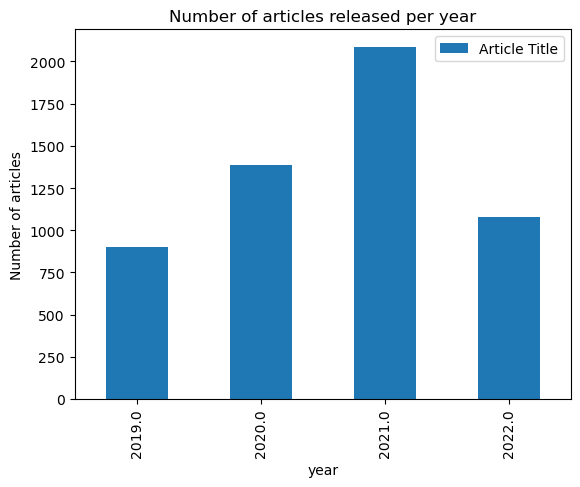

In [630]:
plt.figure(figsize=(12,8))
articles.plot( x='Publication Year', y='Article Title', kind='bar')
plt.title("Number of articles released per year")
plt.xlabel("year", color="black")
plt.ylabel("Number of articles", color="black")
plt.show()

From the table and the graph it shows that more articles were produced in 2021

###### 3.4.2 Performing a bit of some word analysis

In [527]:
all_Info['Publication Year'].value_counts() 

2021.0    2086
2020.0    1389
2022.0    1081
2019.0     899
Name: Publication Year, dtype: int64

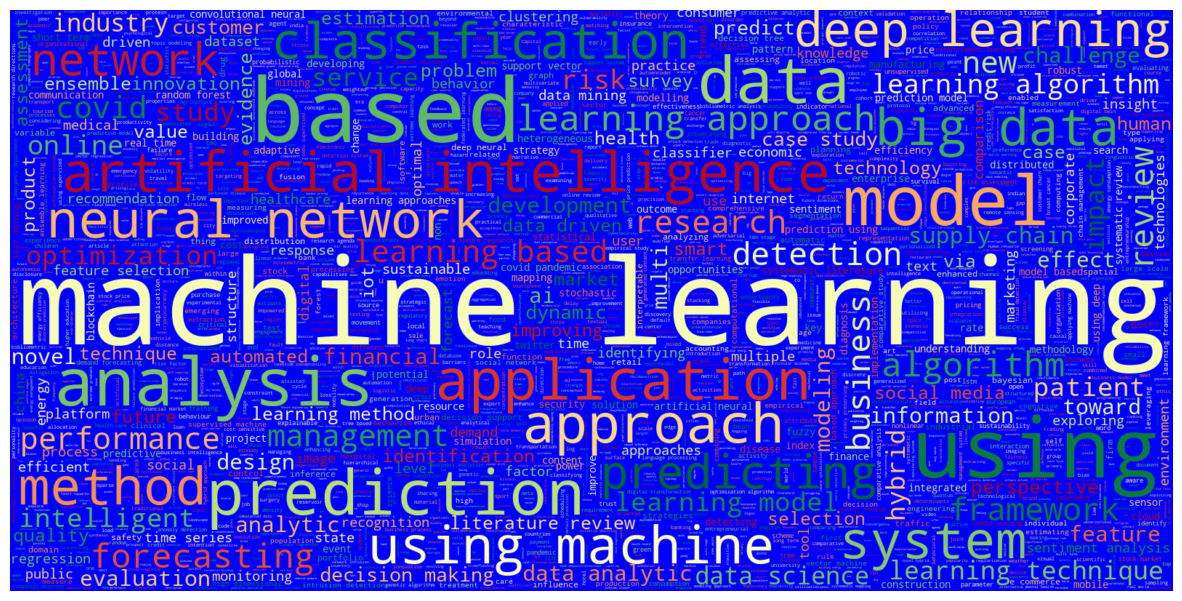

In [782]:
df1= (all_Info['WoS Categories'])
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="Blue", stopwords = STOPWORDS, max_words=2000, max_font_size= 300,  width=1600, height=800)
wc.generate(word_string)
plt.imshow(wc.recolor( colormap= 'RdYlGn' , random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()

Machine learning appears to be the most dominating in the Wos Category

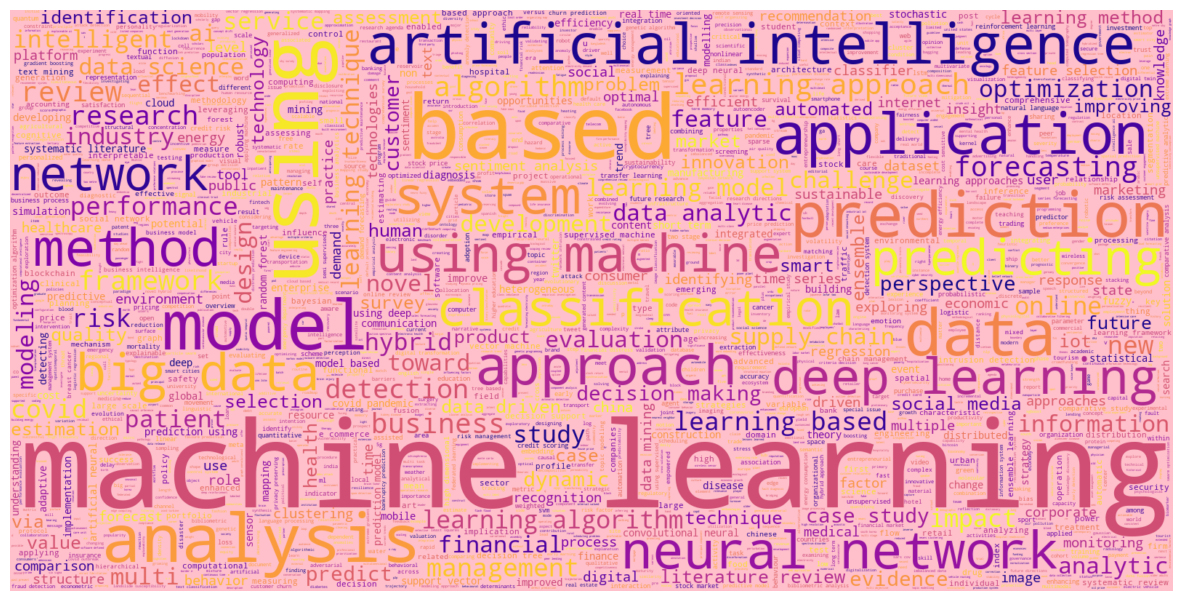

In [476]:
df= (all_Info['Article Title'])
word_string=" ".join(df.str.lower())

plt.figure(figsize=(15,15))
wc = WordCloud(background_color="pink", stopwords = STOPWORDS, max_words=2000, max_font_size= 300,  width=1600, height=800)
wc.generate(word_string)
plt.imshow(wc.recolor( colormap= 'plasma' , random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()

Again the research area that appear the most in the title category is machine learning

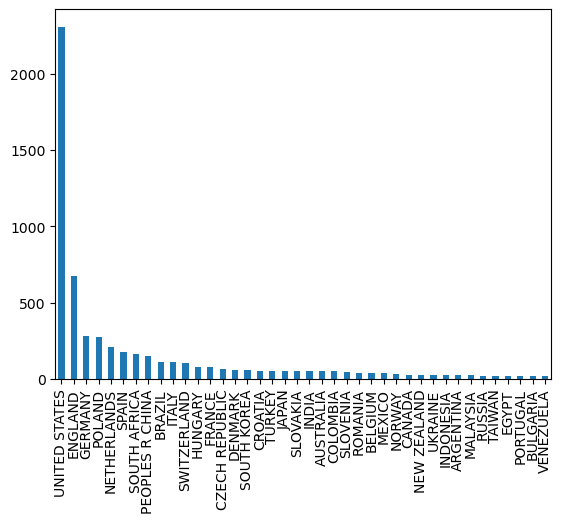

In [635]:
all_Info['Country/Region'].value_counts()[:40].plot(kind='bar')
plt.show()

United states is the most dominating country 

In [633]:
all_Info.isnull().sum()

Publication Type                0
Article Title                   0
Source Title                    0
Since 2013 Usage Count          0
Cited Reference Count           0
Publication Year              479
Times Cited, All Databases      0
Authors                         0
WoS Categories                  0
DOI                           218
Document Type                   0
WoS Categories                  0
Title                           0
Country/Region                  0
RESULT                          0
Source title                    0
CiteScore                       0
2018-21 Citations               0
2018-21 Documents               0
% Cited                         0
Publisher                       0
Percentage                      0
Discipline                      0
Article_Title                   0
dtype: int64

I wont be considering Publication Year and DOI so I will drop them later

In [725]:
all_Info[all_Info['Publication Year'].isnull() == True]

,Publication Type,Article Title,Source Title,Since 2013 Usage Count,Cited Reference Count,Publication Year,"Times Cited, All Databases",Authors,WoS Categories,DOI,...,Country/Region,RESULT,Source title,CiteScore,2018-21 Citations,2018-21 Documents,% Cited,Publisher,Percentage,Discipline
11,J,Business intelligence using machine learning a...,MULTIMEDIA TOOLS AND APPLICATIONS,5,30,NaN,0,"Hamzehi, M; Hosseini, S","Computer Science, Information Systems; Compute...",10.1007/s11042-022-13132-3,...,BRAZIL,0.75,Cell,77.0,148666.0,1931.0,91.0,Elsevier,99.0,"General Biochemistry, Genetics and Molecular B..."
17,J,Identifying research trends of machine learnin...,MEASURING BUSINESS EXCELLENCE,8,82,NaN,0,"Pramanik, P; Jana, RK",Business,10.1108/MBE-07-2021-0094,...,UNITED STATES,1.00,IEEE Communications Surveys and Tutorials,69.4,29083.0,419.0,96.0,IEEE,99.0,Electrical and Electronic Engineering
76,J,The Wells-Du Bois Protocol for Machine Learnin...,VOLUNTAS,0,76,NaN,0,"Monroe-White, T; Lecy, J",Social Issues,10.1007/s11266-022-00479-2,...,UNITED STATES,2.00,The Lancet Public Health,39.7,8820.0,222.0,93.0,Elsevier,99.0,"Public Health, Environmental and Occupational ..."
87,J,"It's a Peoples Game, Isn't It?! A Comparison B...",ENTREPRENEURSHIP THEORY AND PRACTICE,28,132,NaN,8,"Blohm, I; Antretter, T; Siren, C; Grichnik, D;...",Business,10.1177/1042258720945206,...,UNITED STATES,1.00,Annual Review of Fluid Mechanics,37.1,3936.0,106.0,86.0,Annual Reviews Inc.,98.0,Condensed Matter Physics
90,J,Modelling failure rates with machine-learning ...,EUROPEAN FINANCIAL MANAGEMENT,0,62,NaN,0,"Sermpinis, G; Tsoukas, S; Zhang, YQ","Business, Finance",10.1111/eufm.12369,...,UNITED STATES,0.75,Cell Host and Microbe,36.2,24249.0,669.0,87.0,Elsevier,99.0,arasitology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,J,Feature aggregation graph convolutional networ...,BRIEFINGS IN BIOINFORMATICS,6,43,NaN,0,"Bi, XA; Zhou, WY; Luo, S; Mao, YH; Hu, X; Zeng...",Biochemical Research Methods; Mathematical & C...,10.1093/bib/bbac137,...,SLOVENIA,1.00,Trends in Ecology and Evolution,24.7,8054.0,326.0,92.0,Elsevier,99.0,"Ecology, Evolution, Behavior and Systematics"
189,J,Adaptive step-length selection in gradient boo...,COMPUTATIONAL STATISTICS,0,29,NaN,0,"Zhang, BY; Hepp, T; Greven, S; Bergherr, E",Statistics & Probability,10.1007/s00180-022-01199-3,...,ENGLAND,1.00,Nature Ecology and Evolution,24.4,18866.0,773.0,90.0,Springer Nature,99.0,"Ecology, Evolution, Behavior and Systematics"
220,J,Technology and the hybrid workplace: the affec...,INTERNATIONAL JOURNAL OF HUMAN RESOURCE MANAGE...,41,96,NaN,1,"Petani, FJ; Mengis, J",Management,10.1080/09585192.2021.1998186,...,PEOPLES R CHINA,1.00,Intensive Care Medicine,22.4,15000.0,669.0,87.0,Springer Nature,98.0,ritical Care and Intensive Care Medicine
224,J,A Review of Applications of the Bayes Factor i...,PSYCHOLOGICAL METHODS,7,119,NaN,1,"Heck, DW; Boehm, U; Boing-Messing, F; Burkner,...","Psychology, Multidisciplinary",10.1037/met0000454,...,SOUTH AFRICA,0.75,Eurosurveillance,22.1,19504.0,883.0,81.0,European Centre for Disease Prevention and Con...,99.0,"Public Health, Environmental and Occupational ..."


###### 3.6 Text data coding

In [39]:
stop_words=set(stopwords.words("english"))

In [40]:
import re
def text_cleaner(text):
    rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''}  # remove spaces at the beginning
    ]
    for rule in rules:
        for (k, v) in rule.items():
            regex = re.compile(k) #compiles a regular expression pattern provided as a string into a regex pattern object
            text = regex.sub(v, text) # returns a string after replacing the matched pattern in a string with a replacement.
            text = text.rstrip() #removes any trailing characters (characters at the end a string)
            return text.lower() # get the unique format

In [41]:
count= CountVectorizer()

In [103]:
string=np.array(all_Info.Authors)

In [104]:
string1=np.array(all_Info['Article Title'])

In [ ]:
string2=np.array(all_Info['Discipline'])

In [ ]:
string3=np.array(all_Info[' Source Title '])

In [606]:
bag_of_words=count.fit_transform(string)

In [107]:
bag_of_words1=count.fit_transform(string1)

In [599]:
bag_of_words2=count.fit_transform(string2)

In [ ]:
bag_of_words3=count.fit_transform(string3)

In [607]:
Authors= bag_of_words.toarray()

In [108]:
Article_Title=bag_of_words1.toarray()

In [605]:
Discipline=bag_of_words2.toarray()

In [608]:
SourceTitle=bag_of_words2.toarray()

In [ ]:
all_Info['Discipline'] = pd.Series(Discipline.flatten())

In [109]:
all_Info['Article_Title'] = pd.Series(Article_Title.flatten())

In [110]:
all_Info

,Publication Type,Article Title,Source Title,Since 2013 Usage Count,Cited Reference Count,Publication Year,"Times Cited, All Databases",Authors,WoS Categories,DOI,...,Source title,CiteScore,Highest percentile,2018-21 Citations,2018-21 Documents,% Cited,SNIP,SJR,Publisher,Article_Title
1,J,Use of data science and machine learning to an...,DIGITAL EDUCATION REVIEW,4,27,2019.0,0,"Salas-Rueda, RA; Salas-Rueda, RD",Education & Educational Research,NaN,...,Nature Reviews Molecular Cell Biology,140.9,99.0%\n1/386\nMolecular Biology,28743.0,204.0,90.0,19.069,33.213,Springer Nature,0
2,J,Students' perceptions about the use of the tab...,CAMPUS VIRTUALES,6,34,2019.0,5,"Salas-Rueda, RA; Salas-Rueda, EP; Salas-Rueda, RD",Education & Educational Research,NaN,...,The Lancet,115.3,99.0%\n1/826\nGeneral Medicine,198711.0,1723.0,76.0,33.801,15.652,Elsevier,0
3,J,Using Machine Learning in Business Process Re-...,BIG DATA AND COGNITIVE COMPUTING,10,59,2021.0,1,"Al-Anqoudi, Y; Al-Hamdani, A; Al-Badawi, M; He...","Computer Science, Artificial Intelligence; Com...",10.3390/bdcc5040061,...,New England Journal of Medicine,110.5,99.0%\n2/826\nGeneral Medicine,261485.0,2367.0,85.0,20.135,24.907,Massachusetts Medical Society,0
4,J,Data Science Methods and Machine Learning Algo...,TEM JOURNAL-TECHNOLOGY EDUCATION MANAGEMENT IN...,2,15,2020.0,0,"Mrzic, E; Zaimovic, T","Computer Science, Information Systems",10.18421/TEM93-44,...,Reviews of Modern Physics,102.0,99.0%\n1/240\nGeneral Physics and Astronomy,14489.0,142.0,97.0,16.262,21.151,American Physical Society,0
5,J,Assessing the drivers of machine learning busi...,JOURNAL OF BUSINESS RESEARCH,49,78,2020.0,13,"Reis, C; Ruivo, P; Oliveira, T; Faroleiro, P",Business,10.1016/j.jbusres.2020.05.053,...,Chemical Reviews,98.8,99.0%\n1/409\nGeneral Chemistry,92317.0,934.0,97.0,12.313,18.718,American Chemical Society,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,J,Eye tracking: empirical foundations for a mini...,BEHAVIOR RESEARCH METHODS,2,435,NaN,1,"Holmqvist, K; Orbom, SL; Hooge, ITC; Niehorste...","Psychology, Mathematical; Psychology, Experime...",10.3758/s13428-021-01762-8,...,European Journal of Heart Failure,21.5,98.0%\n7/336\nCardiology and Cardiovascular Me...,13912.0,648.0,95.0,3.480,5.231,Wiley-Blackwell,0
247,J,Satisfaction with a digitally-enabled telephon...,NPJ DIGITAL MEDICINE,3,57,2019.0,4,"Coventry, P; Bower, P; Blakemore, A; Baker, E;...",Health Care Sciences & Services; Medical Infor...,10.1038/s41746-019-0080-6,...,IEEE Signal Processing Magazine,21.5,99.0%\n3/590\nApplied Mathematics,6642.0,309.0,77.0,5.339,4.703,IEEE,0
248,J,A multi-country test of brief reappraisal inte...,NATURE HUMAN BEHAVIOUR,67,133,2021.0,15,"Wang, K; Goldenberg, A; Dorison, CA; Miller, J...","Psychology, Biological; Multidisciplinary Scie...",10.1038/s41562-021-01173-x,...,ACS Central Science,21.4,98.0%\n5/280\nGeneral Chemical Engineering,19334.0,905.0,84.0,2.569,4.093,American Chemical Society,0
249,J,The number of tree species on Earth,PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCE...,66,72,2022.0,2,"Gatti, RC; Reich, PB; Gamarra, JGP; Crowther, ...",Multidisciplinary Sciences,10.1073/pnas.2115329119,...,TrAC - Trends in Analytical Chemistry,21.4,98.0%\n2/130\nAnalytical Chemistry,25627.0,1197.0,91.0,2.456,2.194,Elsevier,0


In [595]:
all_Info['Authors'] = pd.Series(Authors.flatten())

In [609]:
all_Info['Source Title'] = pd.Series(SourceTitle.flatten())

In [726]:
#all_Info.info()

###### 3.7 Final data selection

In [621]:
filtered=['Source Title','Since 2013 Usage Count','Cited Reference Count','Discipline','Article_Title','Times Cited, All Databases','Percentage','% Cited','2018-21 Documents','2018-21 Citations','CiteScore','RESULT','Authors']

In [622]:
all_InfoFinal=all_Info.loc[:,filtered]

In [623]:
all_InfoFinal

,Source Title,Since 2013 Usage Count,Cited Reference Count,Discipline,Article_Title,"Times Cited, All Databases",Percentage,% Cited,2018-21 Documents,2018-21 Citations,CiteScore,RESULT,Authors
1,0,4,27,0,0,0,99.0,90.0,204.0,28743.0,140.9,1.00,0
2,0,6,34,0,0,5,99.0,76.0,1723.0,198711.0,115.3,0.75,0
3,0,10,59,0,0,1,99.0,85.0,2367.0,261485.0,110.5,0.75,0
4,0,2,15,0,0,0,99.0,97.0,142.0,14489.0,102.0,0.75,0
5,0,49,78,0,0,13,99.0,97.0,934.0,92317.0,98.8,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0,2,435,0,0,1,98.0,95.0,648.0,13912.0,21.5,1.00,0
247,0,3,57,0,0,4,99.0,77.0,309.0,6642.0,21.5,0.75,0
248,0,67,133,0,0,15,98.0,84.0,905.0,19334.0,21.4,1.00,0
249,0,66,72,0,0,2,98.0,91.0,1197.0,25627.0,21.4,1.00,0


Thank You!